# Analyse AV Classification

The following notebook tries to analyse the antivirus classification of the samples. Specifically the presence of each vendor on the dataset and the FP & FN rate of each vendor.

The FN rate is intuitively easy to extract, if a majority of vendors say a sample is malware, the chance they're all wrong should be minimal, if non zero at all.

The FP rate is harder to extract, as some vendors will correctly identify malware before others.

One possibility is to look only at duplicated submissions where the the classification average goes from goodware to malware. Taking those samples and check for vendors that wrongly classify as malware gives an accurate FP rate at the expense of smaller dataset.

Other possibility is to take vendors with high presence and low FN rate and **ASSUME** their FP rate should be similar to FN. With such vendors one can use them as a baseline for the FP rate of the remaining ones.

This is using Celery, make sure it's running (`celery -A tasks worker --loglevel=info -Ofair`).

In [5]:
import numpy as np
import pandas as pd
from IPython.display import display

pe32_av = pd.read_csv('data/pe32_static_av.csv', dtype=str)
pe32_av['date'] = pd.to_datetime(pe32_av['date'], format='%Y/%m/%d')
# Set date as index
pe32_av = pe32_av.set_index('date')
# pe32_av.drop_duplicates(subset='md5', inplace=True, keep='last')

## Vendors Presence

Check the presence of each vendor in the dataset (meaning percentage they classified a sample, either goodware or badware)

In [6]:
data_size = len(pe32_av)
vendors = pe32_av.columns.values[2:]
vendors_presence = dict()

for vendor in vendors:
    vendors_presence[vendor] = pe32_av[vendor].count()

vendors_presence = pd.Series(data=vendors_presence)
display(vendors_presence.divide(data_size).describe())

# Save vendors presence
vendors_presence.divide(data_size).to_csv(path='data/vendors_presence.csv')

# Filter vendors that appear in over 1% of submissions
vendors_filtered = vendors_presence[vendors_presence.divide(data_size) > 0.01]

display(vendors_filtered.divide(data_size).describe())
pe32_av.drop(vendors_presence[vendors_presence.divide(data_size) <= 0.01].keys(), axis=1, inplace=True)

# Drop samples where no vendor classifies
pe32_av.dropna(how='all', subset=vendors_filtered.keys(), inplace=True)

count    97.000000
mean      0.397988
std       0.324523
min       0.000003
25%       0.005897
50%       0.507460
75%       0.718259
max       0.732732
dtype: float64

count    70.000000
mean      0.550934
std       0.247519
min       0.010435
25%       0.398279
50%       0.707736
75%       0.726456
max       0.732732
dtype: float64

## Vendors FN Rate

Check the FN rate based on the majority of what vendors say. If more than 50% of vendors classify as malware, the odds of being malware should be substantial.

In [7]:
from tasks import count_fn_rate
import datetime
from celery import group

fn_rate = dict.fromkeys(vendors_filtered.keys(), 0)

# Splitting in batches of ~x samples
n_batches = int(len(pe32_av) / 5000)
batches = np.array_split(pe32_av, n_batches)

print('[{0}] Starting batches...'.format(datetime.datetime.now(), idx))
print('[{0}] Sending count tasks...'.format(datetime.datetime.now()))
jobs = group([count_fn_rate.s(fn_rate, batch.to_json(orient='records'), threshold=0.3) for batch in batches])
print('[{0}] Done sending, waiting...'.format(datetime.datetime.now()))
result = jobs.apply_async()
result.join()
print('[{0}] All tasks done.'.format(datetime.datetime.now()))

[2017-03-20 12:52:35.130931] Starting batches...
[2017-03-20 12:52:35.131059] Sending count tasks...
[2017-03-20 12:52:38.792098] Done sending, waiting...
[2017-03-20 12:54:22.461035] All tasks done.


In [1]:
fn_count = np.array(result.get())[:,0]
tp_count = np.array(result.get())[:,1]

fn_rate = pd.Series(fn_count[0])
tp_rate = pd.Series(tp_count[0])

for i in range(len(fn_count[1:])):
    fn_rate = fn_rate.add(pd.Series(fn_count[i + 1]))
    tp_rate = tp_rate.add(pd.Series(tp_count[i + 1]))

display(fn_rate.divide(tp_rate).describe())

import matplotlib.pyplot as plt
fn_sorted = fn_rate.divide(tp_rate).sort_values()
fn_sorted.plot(figsize=(30, 10), xticks=np.arange(len(fn_sorted)), yticks=np.arange(0, 1, 0.1), grid=True)
plt.xticks(rotation='vertical')
plt.show()

display(fn_sorted[fn_sorted <= 0.1])

NameError: name 'np' is not defined

## Vendors FP Rate

Using vendors with FN rate <= 0.1 as a baseline. Assuming these should also have a low FP rate. If the majority of them say a sample is clean, it probably is so other vendors are FP.

In [11]:
from tasks import count_fp_rate2
import datetime
from celery import group

# baseline_vendors = ['gdata', 'antivir', 'mcafee', 'ad-aware', 'bitdefender', 'mcafee-gw-edition', 'f-secure', 'vipre', 'nod32', 'avg', 'arcabit', 'eset-nod32', 'microworld-escan', 'avira', 'kaspersky', 'avast', 'emsisoft', 'sophos', 'avware', 'ikarus', 'invincea', 'crowdstrike', 'panda', 'symantec', 'virusbuster']
baseline_vendors = ['mcafee', 'bitdefender', 'mcafee-gw-edition', 'f-secure', 'nod32', 'avg', 'eset-nod32', 'avira', 'kaspersky', 'avast', 'panda', 'symantec']
fp_rate = dict.fromkeys([v for v in vendors_filtered.keys() if v not in baseline_vendors], 0)

# Splitting in batches of ~x samples
n_batches = int(len(pe32_av) / 5000)
idx = 0
batches = np.array_split(pe32_av, n_batches)

print('[{0}] Starting batches...'.format(datetime.datetime.now(), idx))
print('[{0}] Sending count tasks...'.format(datetime.datetime.now()))
jobs = group([count_fp_rate2.s(fp_rate, baseline_vendors, batch.to_json(orient='records')) for batch in batches])
print('[{0}] Done sending, waiting...'.format(datetime.datetime.now()))
result2 = jobs.apply_async()
result2.join()
print('[{0}] All tasks done.'.format(datetime.datetime.now()))

[2017-03-13 19:56:13.991297] Starting batches...
[2017-03-13 19:56:13.991422] Sending count tasks...
[2017-03-13 19:56:17.035643] Done sending, waiting...
[2017-03-13 19:58:35.758472] All tasks done.


count    58.000000
mean      0.089313
std       0.085011
min       0.000000
25%       0.034216
50%       0.062955
75%       0.121028
max       0.412560
dtype: float64

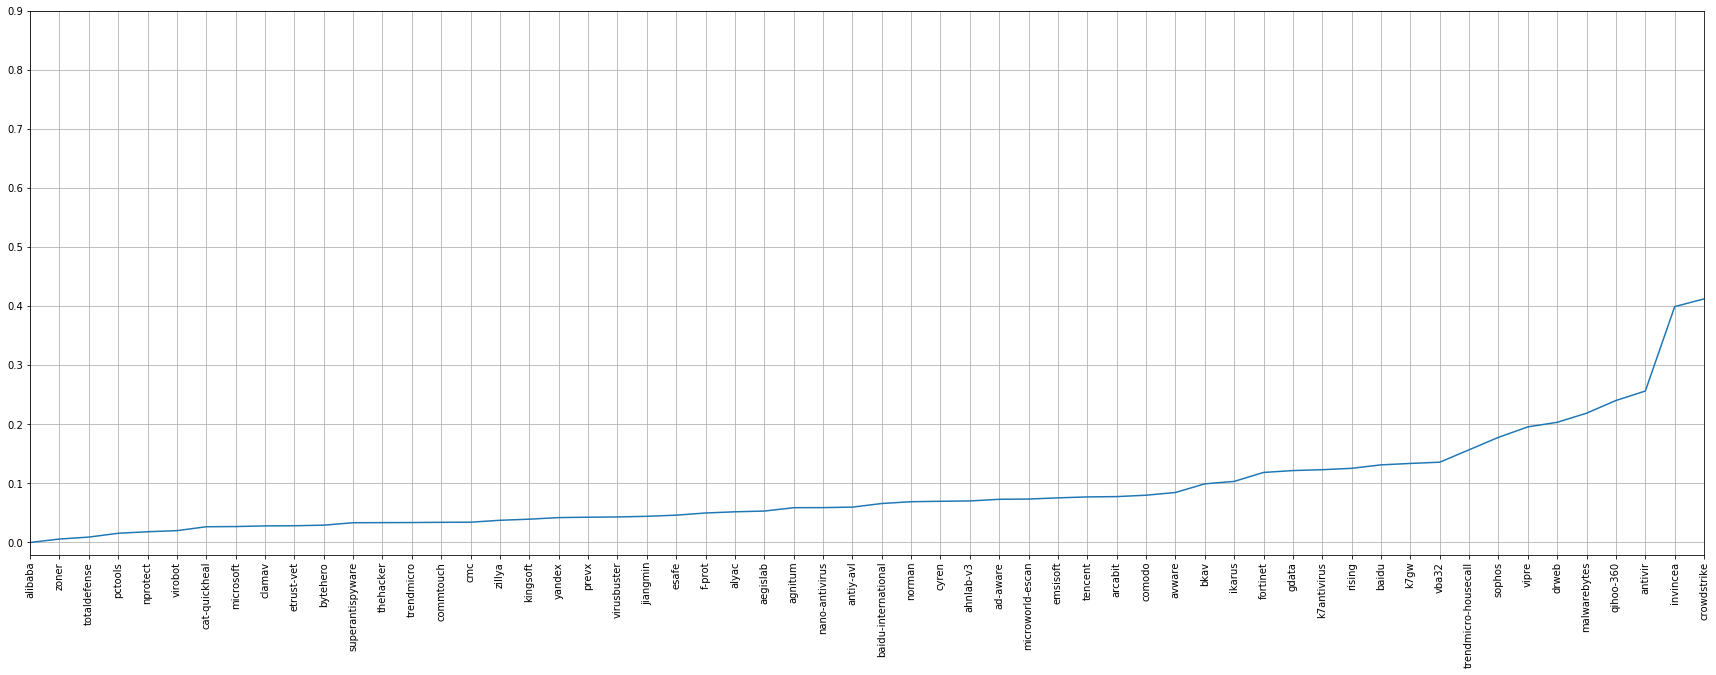

In [12]:
fp_count = np.array(result2.get())[:,0]
tn_count = np.array(result2.get())[:,1]

fp_rate = pd.Series(fp_count[0])
tn_rate = pd.Series(tn_count[0])

for i in range(len(fp_count[1:])):
    fp_rate = fp_rate.add(pd.Series(fp_count[i + 1]))
    tn_rate = tn_rate.add(pd.Series(tn_count[i + 1]))

display(fp_rate.divide(tn_rate).describe())

import matplotlib.pyplot as plt
fp_sorted = fp_rate.divide(tn_rate).sort_values()
fp_sorted.plot(figsize=(30, 10), xticks=np.arange(len(fp_sorted)), yticks=np.arange(0, 1, 0.1), grid=True)
plt.xticks(rotation='vertical')
plt.show()

In [13]:
display(fp_sorted)

alibaba                 0.000000
zoner                   0.005856
totaldefense            0.009156
pctools                 0.015615
nprotect                0.018195
virobot                 0.020063
cat-quickheal           0.026682
microsoft               0.027005
clamav                  0.028094
etrust-vet              0.028362
bytehero                0.029350
superantispyware        0.033493
thehacker               0.033664
trendmicro              0.033791
commtouch               0.034167
cmc                     0.034361
zillya                  0.037618
kingsoft                0.039486
yandex                  0.042173
prevx                   0.042841
virusbuster             0.043247
jiangmin                0.044335
esafe                   0.046295
f-prot                  0.049949
alyac                   0.051988
aegislab                0.053224
agnitum                 0.058922
nano-antivirus          0.059068
antiy-avl               0.059887
baidu-international     0.066023
norman    